In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame
import numpy as np
import pandas as pd
import re

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', scene_stats_df='scene_stats_df')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.


In [4]:

scene_stats_df = data_frames_list['scene_stats_df']


# Visualize Scene Stats


The concept of ‘turbulence’ is well known in hydrodynamics, where it refers to aproperty of ﬂow. A ﬂow is turbulent if its speed and direction are unstable, i.e., changes rapidly and irregularly. Categorical time series like patient engagement order by SORT also consist of ﬂows of events or states in time. We will consider series that have many distinct states and many state changes as being more turbulent than series with fewer distinct states and/or fewer state changes. This implies that the substantive meaning of the various states involved does not play a role in determining the amount of turbulence of the categorical time series.

**Measuring turbulence**: Different measures exist to quantify turbulence in categorical time series. One common approach is the sequence turbulence measure proposed by [Elzinga and Liefbroer (2007)](https://www.researchgate.net/publication/225402919_De-standardization_of_Family-Life_Trajectories_of_Young_Adults_A_Cross-National_Comparison_Using_Sequence_Analysis), which considers both the number of distinct subsequences and the variance of state durations.

**Interpretation**: High turbulence indicates a series with numerous distinct states and frequent transitions, suggesting unpredictability and complexity. Low turbulence signifies a series with fewer distinct states and stable transitions, reflecting order and simplicity.

**Contextual interpretation**: While turbulence measures the formal characteristics of state changes, it's crucial to consider the meaningful interpretation within your specific domain. For example, high turbulence in patient engagement might suggest erratic behavior, while in customer purchase histories, it might reflect diverse interests.

**Limitations**: Turbulence measures don't directly capture the meaning of states or the underlying processes generating the series. Therefore, they should be used in conjunction with other methods that consider domain-specific knowledge.

In [5]:

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def visualize_scene_stats_scatter_plots(
    x_name, y_name, c_name='measure_of_right_ordering', x_description=None, y_description=None, c_description=None, mask_series=None, integer_to_string_dict=None, verbose=False
):
    continuous_threshold = 3
    if x_description is None: x_description = ' '.join([w.title() for w in x_name.split('_')])
    if y_description is None: y_description = ' '.join([w.title() for w in y_name.split('_')])
    legend_title = ' '.join([w.title() for w in c_name.split('_')])
    if isinstance(c_description, list): title_str = f'Scatter Plot of {x_description} vs {y_description} Colored by ' + legend_title
    elif (c_description is None): c_description = legend_title
    if not isinstance(c_description, list): title_str = f'Scatter Plot of {x_description} vs {y_description} Colored by {c_description}'
    
    # Create the scatter plot (mappable object)
    fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.cm.coolwarm
    if mask_series is None: mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull()
    x_series = scene_stats_df.sort_values(c_name)[mask_series][x_name]
    y_series = scene_stats_df.sort_values(c_name)[mask_series][y_name]
    c_series = scene_stats_df.sort_values(c_name)[mask_series][c_name]
    
    # Configure the color dictionary
    if isinstance(c_description, list) or ((integer_to_string_dict is not None) and (c_series.unique().shape[0] < continuous_threshold)):
        color_cycler = nu.get_color_cycler(c_series.unique().shape[0])
        face_color_dict = {}
        for c_category, fc_dict in zip(c_series.unique(), color_cycler()): face_color_dict[str(c_category)] = fc_dict['color']
        if verbose: print(face_color_dict)
        reshape_tuple = (1, -1)
    
    if isinstance(c_description, list):
        for c_category, category_description in zip(c_series.unique(), c_description):
            if verbose: print(c_category, category_description)
            c_mask = (scene_stats_df[c_name] == c_category)
            color = face_color_dict[str(c_category)].reshape(reshape_tuple)
            scatter = ax.scatter(x_series[c_mask], y_series[c_mask], color=color, alpha=0.75, label=category_description)
    elif (integer_to_string_dict is not None) and (c_series.unique().shape[0] < continuous_threshold):
        for c_category in c_series.unique():
            c_mask = (scene_stats_df[c_name] == c_category)
            category_description = integer_to_string_dict.get(c_category, c_category)
            color = face_color_dict[str(c_category)].reshape(reshape_tuple)
            scatter = ax.scatter(x_series[c_mask], y_series[c_mask], color=color, alpha=0.75, label=category_description)
    else: scatter = ax.scatter(x_series, y_series, c=c_series, cmap=cmap, alpha=0.75)
    
    # Add labels and title
    ax.set_xlabel(x_description)
    ax.set_ylabel(y_description)
    ax.set_title(title_str.replace(' Category', ''))
    
    # Add the colorbar and set its tick labels if dictionary available
    if verbose:
        print(f'(not isinstance(c_description, list)) = {bool(not isinstance(c_description, list))}')
        print(
            f'(c_series.unique().shape[0] >= continuous_threshold) = ({c_series.unique().shape[0]} >= {continuous_threshold})'
            f' = {bool(c_series.unique().shape[0] >= continuous_threshold)}'
        )
    if (not isinstance(c_description, list)) and (c_series.unique().shape[0] >= continuous_threshold):
        colorbar = plt.colorbar(scatter, label=legend_title)  # Use the scatter object as the mappable
        if (integer_to_string_dict is not None):
            positions = colorbar.get_ticks()
            labels = [integer_to_string_dict.get(p, round(p, 1)) for p in positions]
            colorbar.set_ticks(positions, labels=labels)
    else: ax.legend(title=legend_title.replace(' Category', ''), loc='lower right')
    
    # Annotate with Spearman's Rank Correlation Coefficient
    s_str = nu.get_spearman_rho_value_latex(x_series, y_series)
    y = 0.9
    if not ('=nan' in s_str):
        text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
        y -= 0.05
    
    # Annotate with Coefficient of Determination
    s_str = nu.get_r_squared_value_latex(x_series, y_series)
    text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    
    return ax


## Color by date with the bin size as a week

In [8]:

min_str = scene_stats_df.session_file_date.min().strftime('%B %d, %Y')
max_str = scene_stats_df.session_file_date.max().strftime('%B %d, %Y')
print(f'The date range for the data set is {min_str} to {max_str}.')

The date range for the data set is March 15, 2022 to September 11, 2023.


In [10]:

mask_series = ~scene_stats_df.session_file_date.isnull()
print(scene_stats_df[mask_series].shape) # (546, 57)
scene_stats_df[mask_series].session_file_date.map(lambda x: x.strftime('%B %d, %Y')).value_counts().head(5)

(880, 59)


March 14, 2023    69
March 15, 2022    51
March 16, 2022    44
April 19, 2023    42
April 20, 2023    41
Name: session_file_date, dtype: int64

In [13]:

mask_series = ~scene_stats_df.session_file_date.isnull()
session_file_week = scene_stats_df[mask_series].session_file_date.map(lambda x: int(str(x.isocalendar()[0]) + str('%02d' % x.isocalendar()[1])))
display(session_file_week.value_counts())
scene_stats_df.loc[mask_series, 'session_file_week'] = session_file_week

202316    122
202311    101
202211     95
202319     83
202310     65
202332     50
202330     43
202331     41
202320     37
202249     36
202248     35
202322     26
202317     25
202323     22
202325     21
202309     20
202336     17
202337     15
202324     11
202333      8
202321      4
202318      3
Name: session_file_date, dtype: int64

In [14]:

mask_series = scene_stats_df.session_file_week.isnull()
mask_series.sum()

0

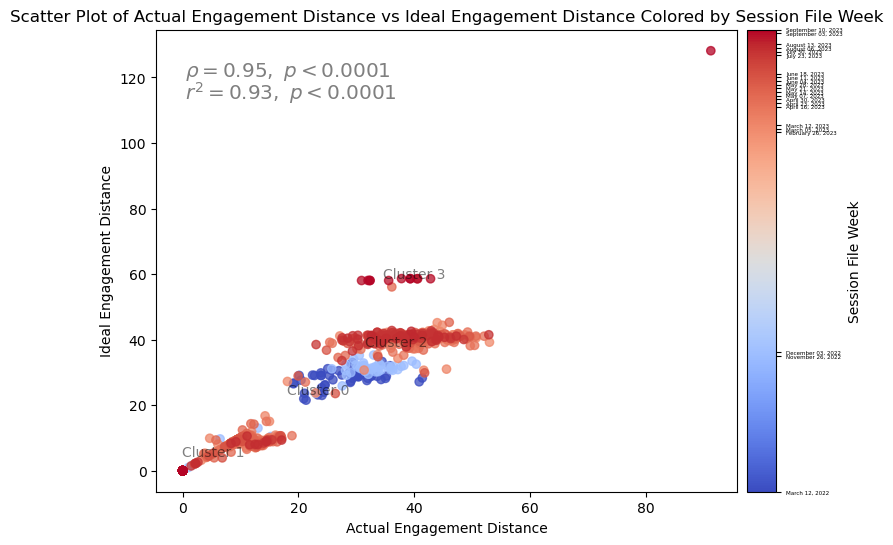

In [39]:

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def get_monday(week_int):
    week_str = str(week_int)
    year = int(week_str[:4])
    week_number = int(week_str[4:])
    
    # Assuming Monday is the first day of the week (ISO standard)
    start_of_year = datetime(year, 1, 1)
    
    # Get Monday of the target week
    monday_of_target_week = start_of_year + timedelta(days=((week_number - 1) * 7))
    
    return(monday_of_target_week)  # Output based on year and week_number

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'session_file_week'
mask_series = ~scene_stats_df.session_file_week.isnull()
integer_to_string_dict = {d: get_monday(d) for d in session_file_week}
continuous_threshold = 3
x_description = ' '.join([w.title() for w in x_name.split('_')])
y_description = ' '.join([w.title() for w in y_name.split('_')])
legend_title = ' '.join([w.title() for w in c_name.split('_')])
c_description = legend_title
title_str = f'Scatter Plot of {x_description} vs {y_description} Colored by {c_description}'

x_series = scene_stats_df.sort_values(c_name)[mask_series][x_name]
y_series = scene_stats_df.sort_values(c_name)[mask_series][y_name]
c_series = scene_stats_df.sort_values(c_name)[mask_series][c_name]

# Create a colormap with blue at the beginning and red at the end
cmap = plt.cm.coolwarm

# Create the scatter plot (mappable object)
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x_series, y_series, c=c_series, cmap=cmap, alpha=0.75)

# Add labels and title
ax.set_xlabel(x_description)
ax.set_ylabel(y_description)
ax.set_title(title_str.replace(' Category', ''))

# Annotate with Spearman's Rank Correlation Coefficient
s_str = nu.get_spearman_rho_value_latex(x_series, y_series)
y = 0.9
if not ('=nan' in s_str):
    text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
    y -= 0.05

# Annotate with Coefficient of Determination
s_str = nu.get_r_squared_value_latex(x_series, y_series)
text_tuple = ax.text(0.05, y, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')

# Add the colorbar and set its tick labels
colorbar_tick_labels = c_series.map(lambda x: get_monday(x).strftime('%B %d, %Y'))

# Convert strings to datetime objects
date_objects = c_series.map(get_monday)

# Convert the dates to lexographically sortable integers
ticks_list = date_objects.map(lambda x: int(str(x.isocalendar()[0]) + str('%02d' % x.isocalendar()[1])))
mask_series = ticks_list.duplicated(keep='first')
ticks_list.loc[mask_series] = None

# Normalize days to be between 0 and 1 (representing year progression)
norm = mpl.colors.Normalize(vmin=min(ticks_list), vmax=max(ticks_list))

# Create a divider for existing axes instance
divider = make_axes_locatable(ax)

# Append axes to the right of the main plot
cax = divider.append_axes('right', size='5%', pad=0.1)

# Create a new color bar in the appended axes
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', ticks=ticks_list, format='%b %d', label=legend_title)
# cb1.set_label(legend_title)
positions = cb1.get_ticks()
cb1.set_ticks(positions, labels=colorbar_tick_labels, fontsize=4)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i, j in zip([0, 1, 2, 3], [1, 2, 0, 3]):
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {j}', centroid, fontsize=10, ha='center', alpha=0.5)


## Color by other columns

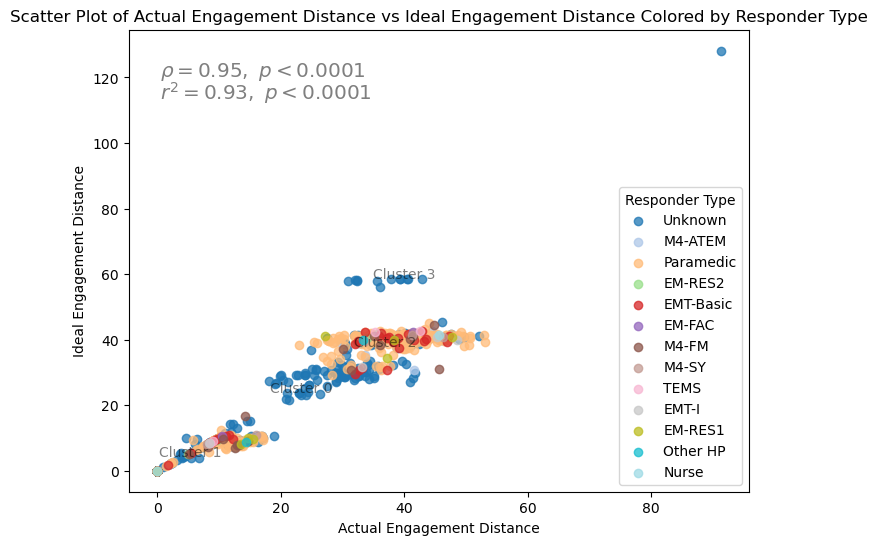

In [6]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'responder_type_category'
mask_series = ~scene_stats_df.responder_type.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].responder_type)
scene_stats_df[c_name] = scene_stats_df.responder_type.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

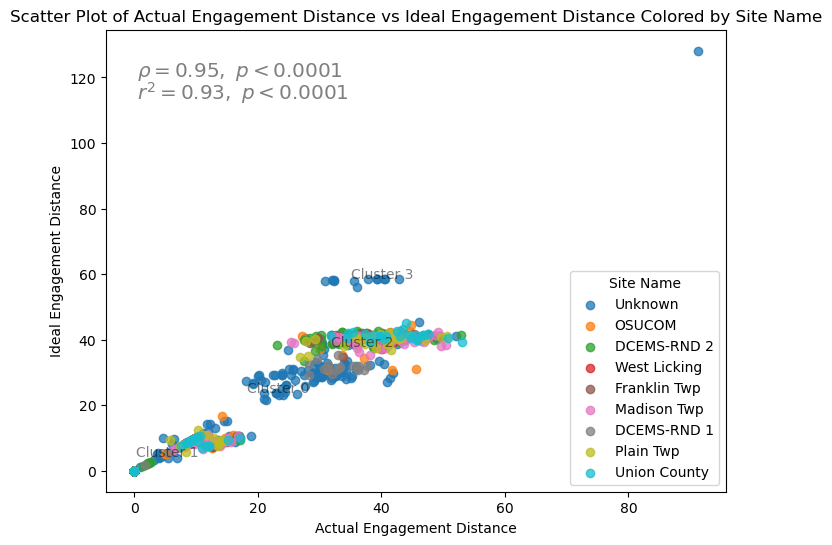

In [7]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'site_name_category'
mask_series = ~scene_stats_df.site_name.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].site_name)
scene_stats_df[c_name] = scene_stats_df.site_name.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

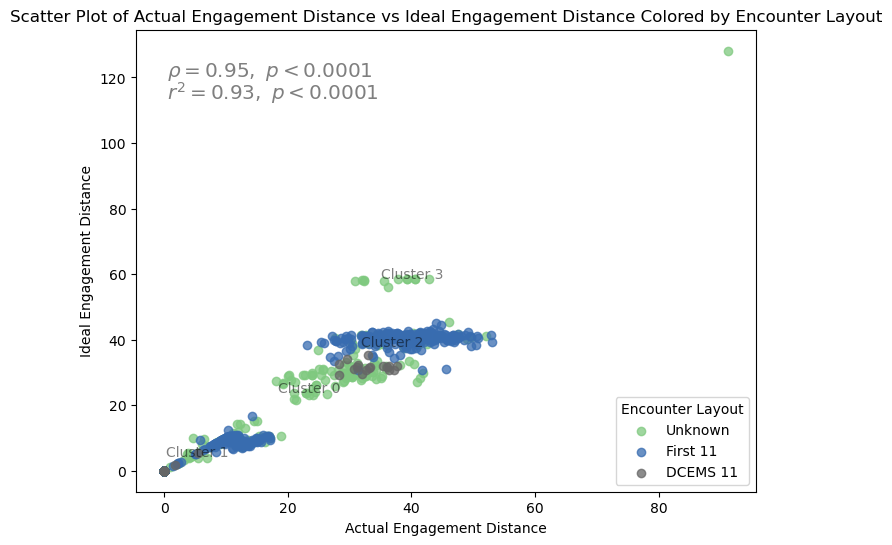

In [8]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'encounter_layout_category'
mask_series = ~scene_stats_df.encounter_layout.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].encounter_layout)
scene_stats_df[c_name] = scene_stats_df.encounter_layout.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
c_description = ['Unknown', 'First 11', 'DCEMS 11']
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, c_description=c_description, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

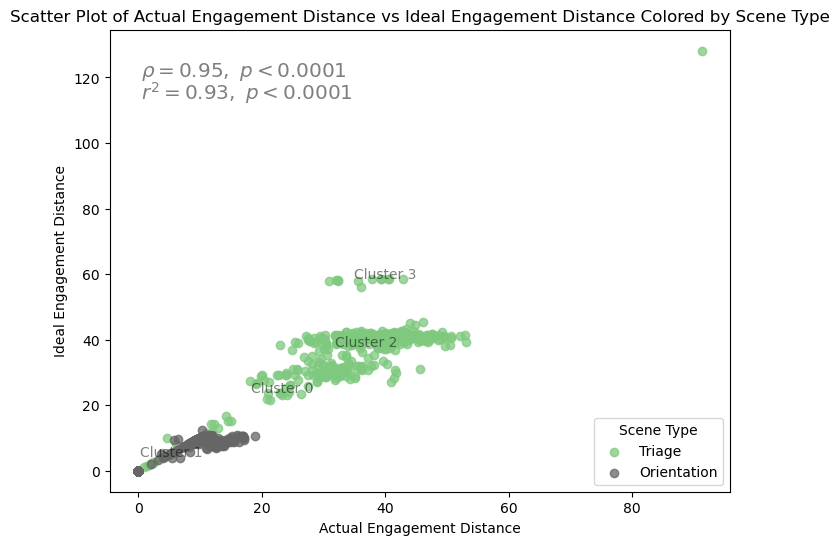

In [9]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'scene_type_category'
mask_series = ~scene_stats_df.scene_type.isnull()
_, string_to_integer_dict = nu.convert_strings_to_integers(scene_stats_df[mask_series].scene_type)
scene_stats_df[c_name] = scene_stats_df.scene_type.map(lambda x: string_to_integer_dict.get(x, np.nan))
integer_to_string_dict = {v: k for k, v in string_to_integer_dict.items()}
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, integer_to_string_dict=integer_to_string_dict, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

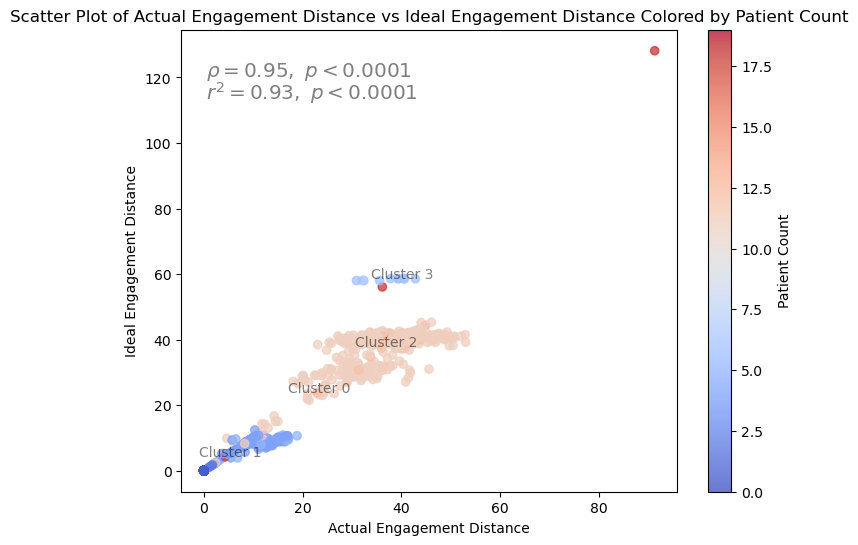

In [10]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_name = 'patient_count'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_name=c_name, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

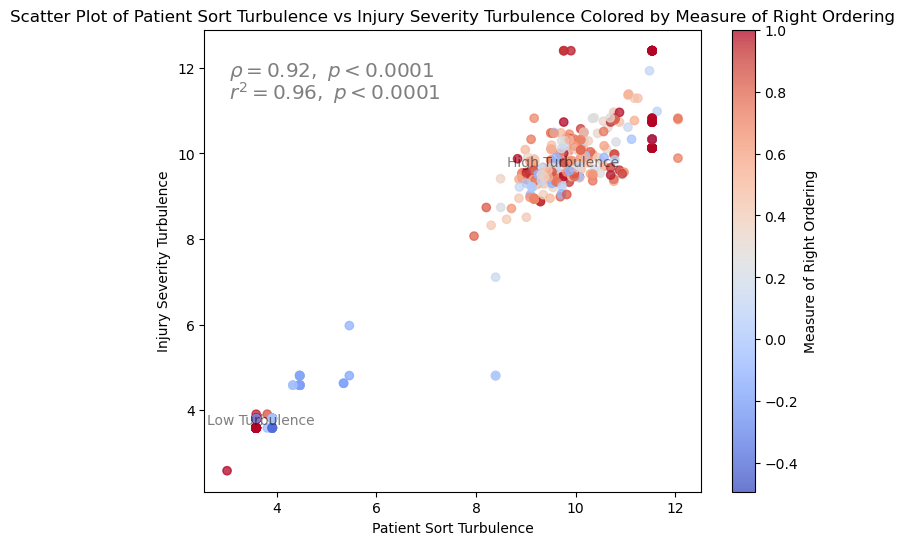

In [11]:

x_name = 'patient_sort_turbulence'
y_name = 'injury_severity_turbulence'
c_description = 'Measure of Right Ordering'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
X = scene_stats_df[columns_list].values
mask = ~np.isnan(X).any(axis=1)
filtered_X = X[mask]
dbscan = DBSCAN(eps=0.5, min_samples=55.0)
dbscan.fit(filtered_X)
labels = dbscan.labels_
annotations_list = ['High Turbulence', 'Low Turbulence']
for i in [0, 1]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(annotations_list[i], centroid, fontsize=10, ha='center', alpha=0.5)

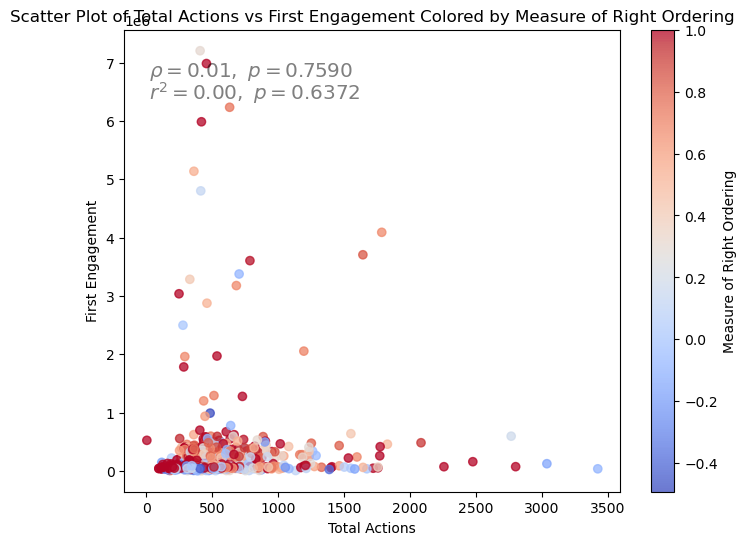

In [12]:

x_name = 'total_actions'
y_name = 'first_engagement'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
c_description = 'Measure of Right Ordering'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, mask_series=mask_series, verbose=False)

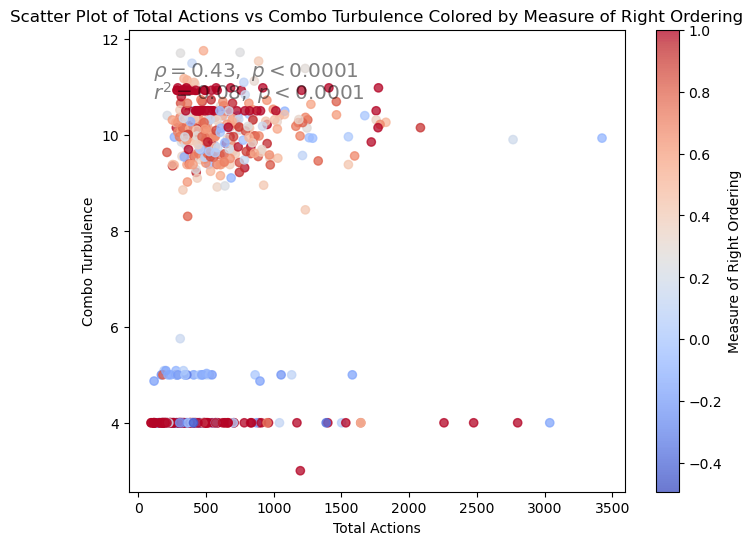

In [13]:

x_name = 'total_actions'
y_name = 'combo_turbulence'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
c_description = 'Measure of Right Ordering'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, mask_series=mask_series, verbose=False)

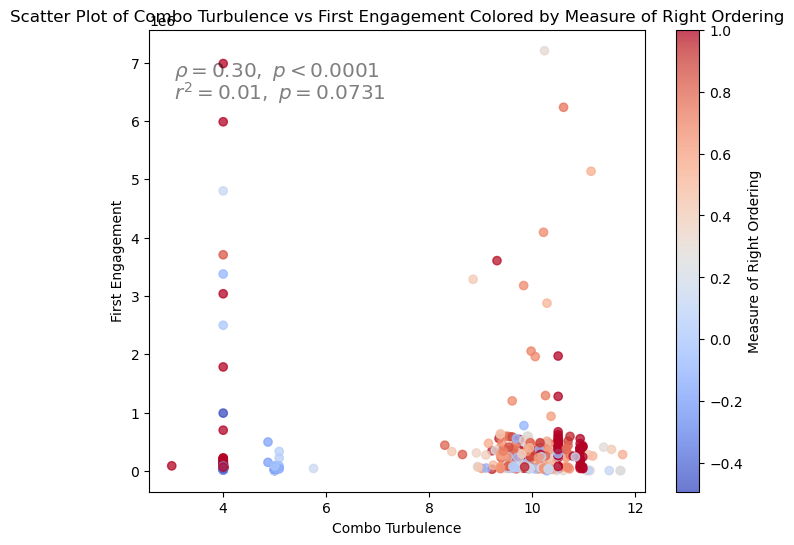

In [14]:

x_name = 'combo_turbulence'
y_name = 'first_engagement'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull() & (scene_stats_df[x_name] < 4000)
c_description = 'Measure of Right Ordering'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, mask_series=mask_series, verbose=False)

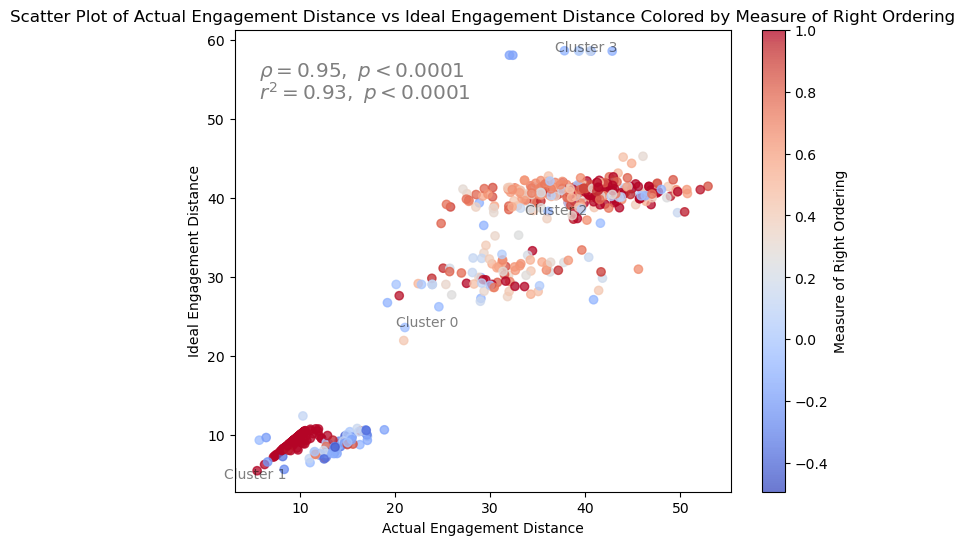

In [15]:

x_name = 'actual_engagement_distance'
y_name = 'ideal_engagement_distance'
c_description = 'Measure of Right Ordering'
mask_series = ~scene_stats_df[x_name].isnull() & ~scene_stats_df[y_name].isnull()
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, mask_series=mask_series, verbose=False)

# Annotate label centroids with cluster labels
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
dbscan = DBSCAN(eps=2.75, min_samples=6)
dbscan.fit(filtered_X)
labels = dbscan.labels_
for i in [0, 1, 2, 3]:
    arr = filtered_X[labels == i]
    centroid = np.mean(arr, axis=0)
    ax.annotate(f'Cluster {i}', centroid, fontsize=10, ha='center', alpha=0.5)

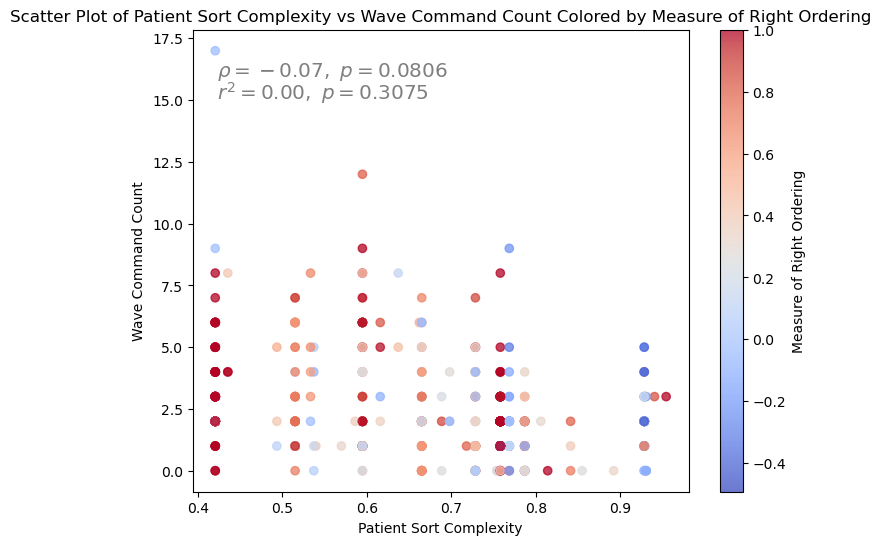

In [16]:

x_name = 'patient_sort_complexity'
y_name = 'wave_command_count'
c_description = 'Measure of Right Ordering'
ax = visualize_scene_stats_scatter_plots(x_name, y_name, c_description=c_description, verbose=False)


# Maintenance

In [178]:

# Find dbscan parameter settings
cluster_count = 4
columns_list = [x_name, y_name]
filtered_X = scene_stats_df[mask_series][columns_list].values
for eps in [0.0005, 0.005, 0.0275, 0.05, 0.275, 0.5, 2.75, 5, 27.5, 50, 500]:
    for min_samples in [0, 1, 6, 10, 55, 100, 550, 1000]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(filtered_X)
        labels = dbscan.labels_
        uniques_array, counts_array = np.unique(labels, return_counts=True)
        filtered_array = uniques_array[uniques_array != -1]
        if (filtered_array.shape[0] == cluster_count):
            upper_array = np.unique(labels[(filtered_X[:, 1] > 50)])
            if upper_array[upper_array != -1].shape[0]:
                print(f'dbscan = DBSCAN(eps={eps}, min_samples={min_samples})')
                print(filtered_array)
                print(counts_array[uniques_array != -1])

dbscan = DBSCAN(eps=2.75, min_samples=6)
[0 1 2 3]
[ 12 483 358   6]
dbscan = DBSCAN(eps=5, min_samples=0)
[0 1 2 3]
[375 485  12   1]
dbscan = DBSCAN(eps=5, min_samples=1)
[0 1 2 3]
[375 485  12   1]


In [171]:

filtered_X[:, 1].shape, labels.shape

((873,), (873,))

In [172]:

filtered_X[(filtered_X[:, 1] > 50)]

array([[ 36.13045411,  56.08428593],
       [ 39.32145779,  58.6238369 ],
       [ 32.38248359,  58.05317854],
       [ 37.8098048 ,  58.6231322 ],
       [ 32.02456833,  58.06355996],
       [ 35.5850193 ,  58.03611234],
       [ 39.32645142,  58.57938724],
       [ 32.31503216,  58.03611234],
       [ 91.24793472, 128.14862595],
       [ 40.597501  ,  58.57855394],
       [ 42.82316163,  58.57855394],
       [ 40.500276  ,  58.57855394],
       [ 30.90328614,  58.03611234]])

In [174]:

labels[(filtered_X[:, 1] > 50)]

array([-1,  3, -1,  3, -1, -1,  3, -1, -1,  3,  3,  3, -1])

In [148]:

np.mean([100, 1000])

550.0